## Experiment 1: BFGS vs Adam on synthetic SE data

In [142]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm.auto import tqdm
from gp import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


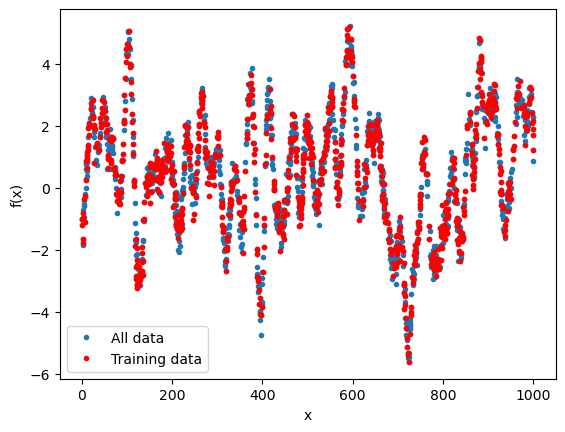

In [2]:
n_data = 2000
n_train = 1000
X = 1000*torch.rand(n_data,1)
hypers = [5, 10, 0.1]
gp_true = GP(hypers = hypers)
y = gp_true.sample_form_prior(X)
#y = y.squeeze()    # make sure it’s 1D

X_data = X.detach().cpu()
y_data = y.detach().cpu()

idx = torch.randperm(n_data)[:n_train]
# subset of the data

X_train = X_data[idx]
y_train = y_data[idx]

plt.plot(X_data, y_data, '.', label="All data")
plt.plot(X_train, y_train, 'r.', label="Training data")
plt.legend()

plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [136]:
#training setting: modify for Adam vs BFGS
M=100
tol = 1e-3
optimizer = 'Adam' ## or 'Adam'
if optimizer == 'BFGS':
    n_steps = 200 
    lr = 0.01 
elif optimizer == 'Adam':
    n_steps = 5000 
    lr = 0.1

In [137]:
# Vanilla GP (NLL)
gp_nll = GP(X_train, y_train, kernel = 'SE')

d_train1 = gp_nll.train_step(obj = 'nll', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol)

In [138]:
# SparseGP (ELBO)
gp_elbo = GP(X_train, y_train, kernel = 'SE', M=M, method = 'VFE')

d_train2 = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol)

In [139]:
# SparseGP (proj)
gp_proj = GP(X_train, y_train, kernel = 'SE', M=M, method = 'proj-localised')

d_train3 = gp_proj.train_step(obj = 'proj', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol)


In [140]:
print("Negative log-likelihood per method:")
print(f"NLL: {gp_nll.nll().detach().numpy().flatten()}")
print(f"ELBO: {gp_elbo.nll().detach().numpy().flatten()}")
print(f"Proj: {gp_proj.nll().detach().numpy().flatten()}")

print("Hypers:")

print(f"NLL: {gp_nll.hypers.detach().numpy().flatten()}")
print(f"ELBO: {gp_elbo.hypers.detach().numpy().flatten()}")
print(f"Proj: {gp_proj.hypers.detach().numpy().flatten()}")




Negative log-likelihood per method:
NLL: [571.4347]
ELBO: [634.04144]
Proj: [577.07574]
Hypers:
NLL: [3.6104571  9.62059833 0.10371205]
ELBO: [ 2.5668111  11.61385462  0.15503829]
Proj: [3.60892877 9.31491749 0.12185955]


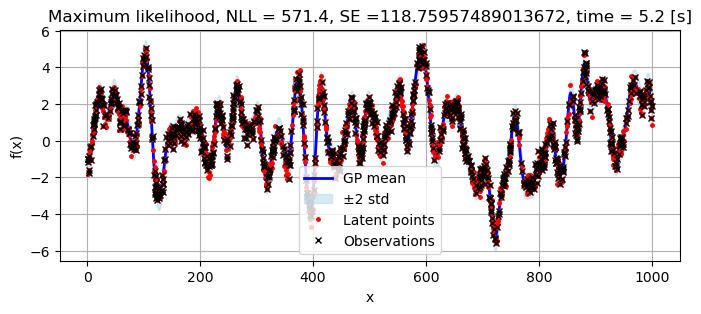

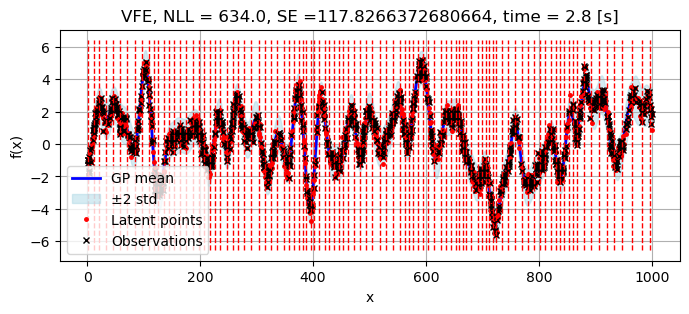

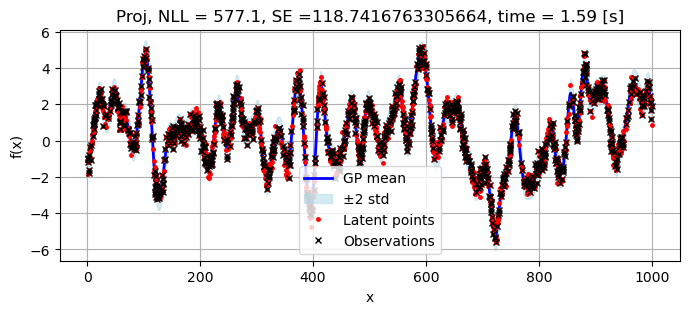

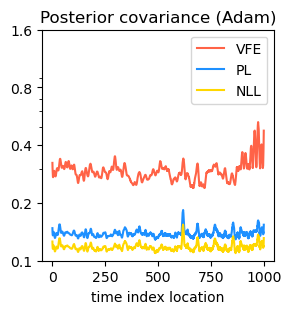

In [141]:
# plots
x_new = X_data.clone().detach()
x_new, _ = torch.sort(x_new, dim=0)  # returns sorted values


#NLL
gp_nll.compute_moments()
mu1,var1 = gp_nll.forward(x_new)
SE1 = torch.norm(mu1-y_data)
ax = plot_gp(x_new, mu1, var1, X_obs=X_train, y_obs=y_train, X_latent=X_data, y_latent=y_data, 
             title = f'Maximum likelihood, NLL = {gp_nll.nll().detach().numpy().flatten()[0]:.1f}, SE ={SE1}, time = {d_train1['time']:.3g} [s]')

#print(var)
#ELBO
mu2,var2 = gp_elbo.forward_VFE(x_new)
SE2 = torch.norm(mu2-y_data)
ax = plot_gp(x_new, mu2, var2, X_obs=X_train, y_obs=y_train, X_latent=X_data, y_latent=y_data,
             title = f'VFE, NLL = {gp_elbo.nll().detach().numpy().flatten()[0]:.1f}, SE ={SE2}, time = {d_train2['time']:.3g} [s]')
Z_np = gp_elbo.Z.detach().cpu().numpy()
ax.vlines(Z_np, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],
          colors="r", linestyles="--", linewidth=1.0)

#proj
gp_proj.compute_moments()
mu3,var3 = gp_proj.forward(x_new)
SE3 = torch.norm(mu3-y_data)
ax = plot_gp(x_new, mu3, var3, X_obs=X_train, y_obs=y_train, X_latent=X_data, y_latent=y_data,
             title = f'Proj, NLL = {gp_proj.nll().detach().numpy().flatten()[0]:.1f}, SE ={SE3}, time = {d_train3['time']:.3g} [s]')


#plot variances:
plt.figure(figsize=(3,3))
plt.semilogy(x_new, var2.detach().numpy(), color='tomato', label='VFE')
plt.semilogy(x_new, var3.detach().numpy(), color='dodgerblue', label='PL')
plt.semilogy(x_new, var1.detach().numpy(), color='gold', label='NLL')
plt.yticks([0.1, 0.2, 0.4, 0.8, 1.6],[0.1, 0.2, 0.4, 0.8, 1.6])
plt.title(f'Posterior covariance ({optimizer})')
plt.xlabel('time index location')
plt.legend()
plt.savefig(f"img/exp0-{optimizer}.pdf", bbox_inches='tight', pad_inches=0)



